# 核トレーニングデータを検査する

データ読み込みと前処理コードを検査し、視覚化する。
https://www.kaggle.com/c/data-science-bowl-2018

In [56]:
import os
import sys
import itertools
import math
import logging
import json
import re
import random
import time
import concurrent.futures
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon
import imgaug
from imgaug import augmenters as iaa

# プロジェクトのRoot directory 　getcwd():作業ディレクトリ（カレントディレクトリ）を取得
ROOT_DIR = os.getcwd()
if ROOT_DIR.endswith("samples/nucleus"): #endswith():最後文字で終了する場合True
    # Go up two levels to the repo root　二つ階層を上がる
    ROOT_DIR = os.path.dirname(os.path.dirname(ROOT_DIR))
    
# Mask RCNNをインポート
sys.path.append(ROOT_DIR)
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
from mrcnn import model as modellib
from mrcnn.model import log

import nucleus

%matplotlib inline 

In [57]:
os.getcwd()


'/Users/okunagatatsuya/diveintocode-term2/sprint18-19/Mask_RCNN-master/datasets/nucleus'

In [58]:
os.path.dirname(os.path.dirname(ROOT_DIR))


'/Users/okunagatatsuya/diveintocode-term2/sprint18-19/Mask_RCNN-master'

In [59]:
# Comment out to reload imported modules if they change
# %load_ext autoreload
# %autoreload 2

In [60]:
ls ../../

LICENSE*          assets/           logs/             samples/
MANIFEST.in*      datasets/         mrcnn/            setup.cfg*
README.md*        images/           requirements.txt* setup.py*


## Configurations

In [61]:
# Dataset directory
DATASET_DIR = ROOT_DIR #os.path.join(ROOT_DIR, "../../datasets/nucleus")

#nucleus.pyの設定を使用しますが、上書きします
#イメージのサイズ変更はここで実際のサイズを参照してください
class NoResizeConfig(nucleus.NucleusConfig):
    IMAGE_RESIZE_MODE = "none"
    
config = NoResizeConfig()

In [62]:
DATASET_DIR

'/Users/okunagatatsuya/diveintocode-term2/sprint18-19/Mask_RCNN-master/datasets/nucleus'

## Notebook Preferences

In [85]:
def get_ax(rows=1, cols=1, size=16):
    """Matplotlib Axes配列を返し、ノートブック内のすべての視覚化で使用されます。 
    グラフサイズを制御する中心点を提供します。
    
   サイズ属性を調整してイメージのレンダリングの程度を制御する
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

コンペサイトからデータセットをダウンロードしてください。 解凍し、 `mask_rcnn / datasets / nucleus`に保存してください。 別のディレクトリを使用する場合は、上記の `DATASET_DIR`変数を変更してください。

https://www.kaggle.com/c/data-science-bowl-2018/data

In [64]:
# Load dataset
dataset = nucleus.NucleusDataset()
'''サブセットは、stage1_train、stage1_test、...などのサブディレクトリの名前です。 
次の特別な値を使用することもできます。
train：stage1_trainを読み込みますが、検証画像は除外します
val：stage1_trainから検証画像を読み込みます。 検証イメージのリストについては、
nucleus.pyを参照してください。
'''
dataset.load_nucleus(DATASET_DIR, subset="train")
#データセットを使用する前に呼び出す必要があります
dataset.prepare()

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Image Count: 645
Class Count: 2
  0. BG                                                
  1. nucleus                                           


## サンプルを表示

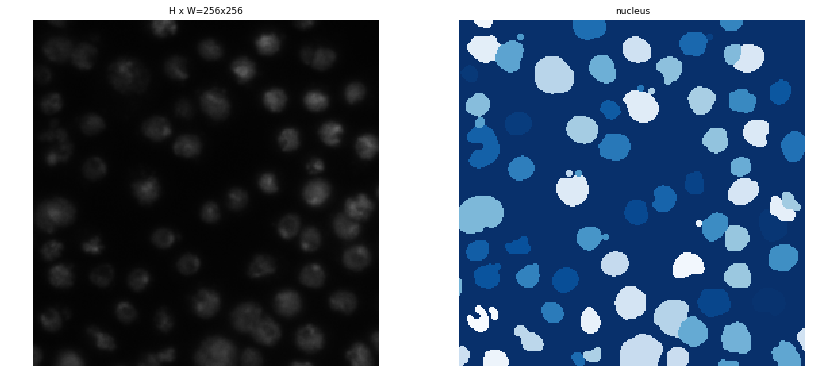

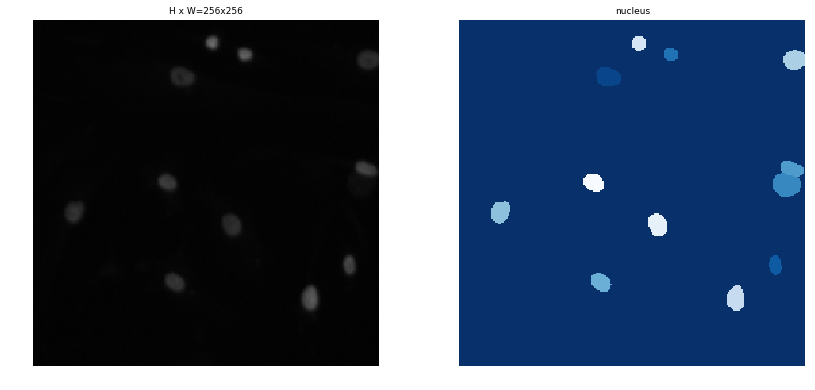

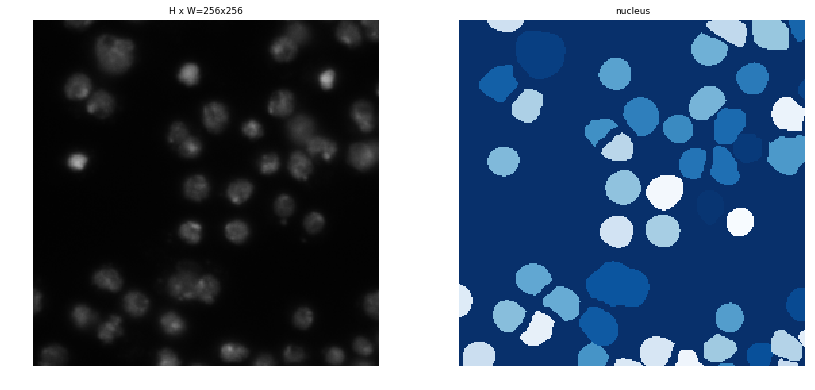

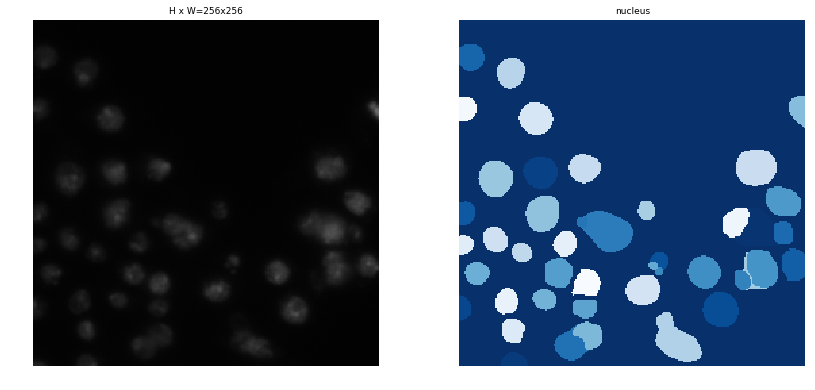

In [66]:
# Load and display random samples
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id) #return mask, np.ones([mask.shape[-1]], dtype=np.int32
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names, limit=1)

molded_image             shape: (256, 320, 3)         min:   28.00000  max:  232.00000  uint8
mask                     shape: (256, 320, 42)        min:    0.00000  max:    1.00000  bool


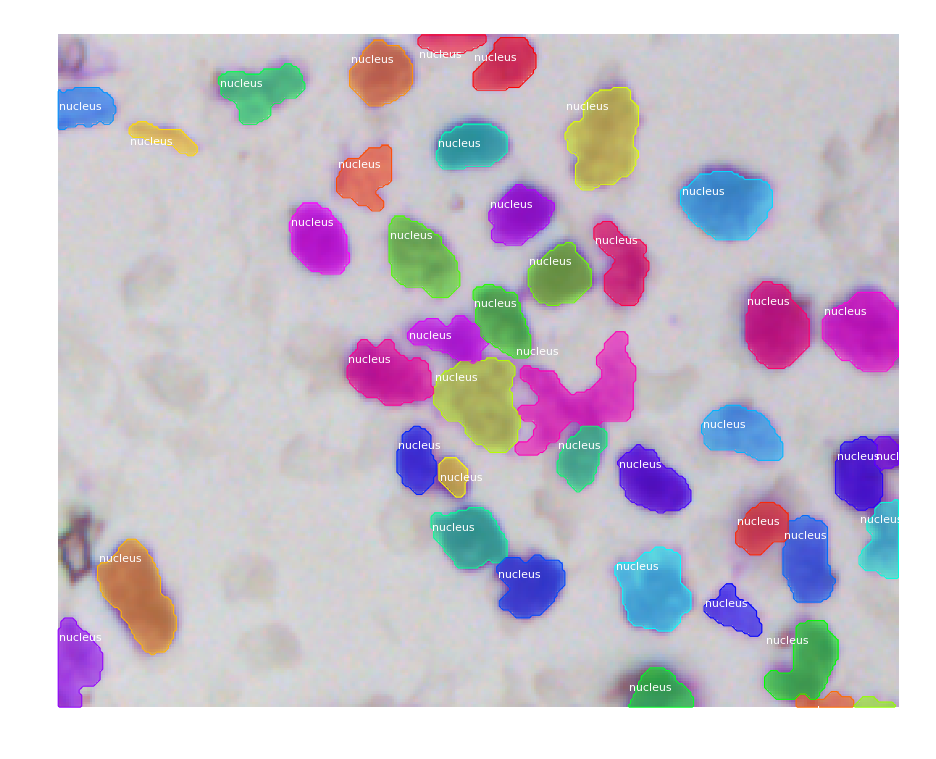

In [132]:
# 特定のイメージをソースIDでロードする例
source_id = "ed5be4b63e9506ad64660dd92a098ffcc0325195298c13c815a73773f1efc279"

# データセットimage_idにソースIDをマップする
# nucleus prefixを確認:NucleusDatasetのデータセットに与えられた名前
image_id = dataset.image_from_source_map["nucleus.{}".format(source_id)]

# Load and display
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
        dataset, config, image_id, use_mini_mask=False)
log("molded_image", image)
log("mask", mask)
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names,
                            show_bbox=False)

## データセットの統計

データセット内のすべてのイメージをループし、集計統計情報を収集します。

In [12]:
def image_stats(image_id):
    """Returns a dict of stats for one image."""
    image = dataset.load_image(image_id)
    mask, _ = dataset.load_mask(image_id)
    bbox = utils.extract_bboxes(mask)
    # Sanity check
    assert mask.shape[:2] == image.shape[:2]
    # Return stats dict
    return {
        "id": image_id,
        "shape": list(image.shape),
        "bbox": [[b[2] - b[0], b[3] - b[1]]
                 for b in bbox
                 # Uncomment to exclude nuclei with 1 pixel width
                 # or height (often on edges)
                 # if b[2] - b[0] > 1 and b[3] - b[1] > 1
                ],
        "color": np.mean(image, axis=(0, 1)),
    }

# Loop through the dataset and compute stats over multiple threads
# This might take a few minutes
t_start = time.time()
with concurrent.futures.ThreadPoolExecutor() as e:
    stats = list(e.map(image_stats, dataset.image_ids))
t_total = time.time() - t_start
print("Total time: {:.1f} seconds".format(t_total))

Total time: 81.6 seconds


### 画像サイズの統計

Image Count:  645
Height  mean: 332.55  median: 256.00  min: 256.00  max: 1024.00
Width   mean: 374.53  median: 256.00  min: 256.00  max: 1272.00
Color   mean (RGB): 41.70 37.98 46.30


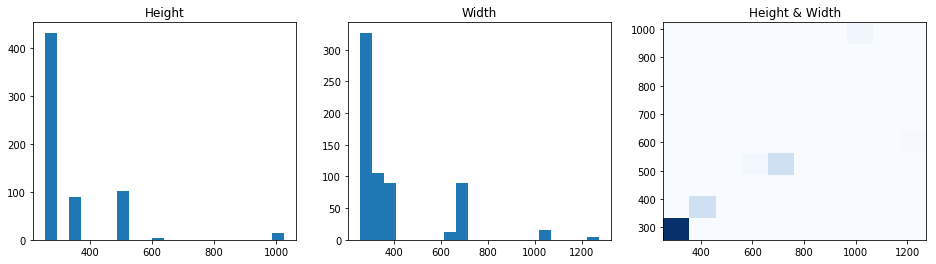

In [13]:
# 画像統計
image_shape = np.array([s['shape'] for s in stats])
image_color = np.array([s['color'] for s in stats])
print("Image Count: ", image_shape.shape[0])
print("Height  mean: {:.2f}  median: {:.2f}  min: {:.2f}  max: {:.2f}".format(
    np.mean(image_shape[:, 0]), np.median(image_shape[:, 0]),
    np.min(image_shape[:, 0]), np.max(image_shape[:, 0])))
print("Width   mean: {:.2f}  median: {:.2f}  min: {:.2f}  max: {:.2f}".format(
    np.mean(image_shape[:, 1]), np.median(image_shape[:, 1]),
    np.min(image_shape[:, 1]), np.max(image_shape[:, 1])))
print("Color   mean (RGB): {:.2f} {:.2f} {:.2f}".format(*np.mean(image_color, axis=0)))

# Histograms
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
ax[0].set_title("Height")
_ = ax[0].hist(image_shape[:, 0], bins=20)
ax[1].set_title("Width")
_ = ax[1].hist(image_shape[:, 1], bins=20)
ax[2].set_title("Height & Width")
_ = ax[2].hist2d(image_shape[:, 1], image_shape[:, 0], bins=10, cmap="Blues")

### イメージ統計ごとの核

Nuclei/Image
Image area <=  256**2:  mean: 28.7  median: 22.0  min: 1.0  max: 101.0
Image area <=  600**2:  mean: 34.3  median: 25.0  min: 1.0  max: 151.0
Image area <= 1300**2:  mean: 104.6  median: 101.0  min: 4.0  max: 375.0


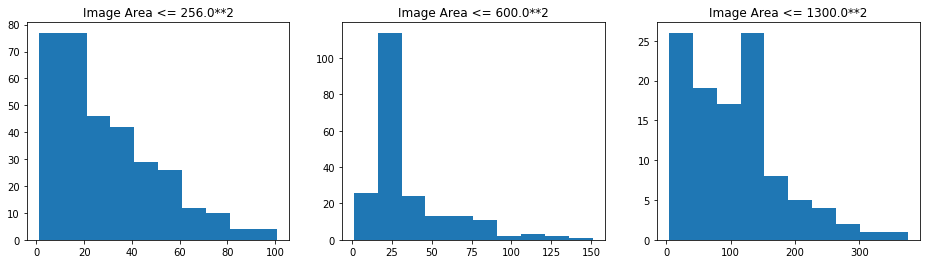

In [14]:
# 画像領域別セグメント
image_area_bins = [256**2, 600**2, 1300**2]

print("Nuclei/Image")
fig, ax = plt.subplots(1, len(image_area_bins), figsize=(16, 4))
area_threshold = 0
for i, image_area in enumerate(image_area_bins):
    nuclei_per_image = np.array([len(s['bbox']) 
                                 for s in stats 
                                 if area_threshold < (s['shape'][0] * s['shape'][1]) <= image_area])
    area_threshold = image_area
    if len(nuclei_per_image) == 0:
        print("Image area <= {:4}**2: None".format(np.sqrt(image_area)))
        continue
    print("Image area <= {:4.0f}**2:  mean: {:.1f}  median: {:.1f}  min: {:.1f}  max: {:.1f}".format(
        np.sqrt(image_area), nuclei_per_image.mean(), np.median(nuclei_per_image), 
        nuclei_per_image.min(), nuclei_per_image.max()))
    ax[i].set_title("Image Area <= {:4}**2".format(np.sqrt(image_area)))
    _ = ax[i].hist(nuclei_per_image, bins=10)

### 核の大きさ統計


Image Area <= 256**2
  Total Nuclei:  9378
  Nucleus Height. mean: 14.14  median: 13.00  min: 2.00  max: 60.00
  Nucleus Width.  mean: 14.38  median: 13.00  min: 2.00  max: 64.00
  Nucleus Area.   mean: 232.19  median: 168.00  min: 24.00  max: 2880.00

Image Area <= 600**2
  Total Nuclei:  7177
  Nucleus Height. mean: 28.53  median: 23.00  min: 2.00  max: 126.00
  Nucleus Width.  mean: 29.56  median: 24.00  min: 1.00  max: 117.00
  Nucleus Area.   mean: 1086.77  median: 529.00  min: 21.00  max: 13560.00

Image Area <= 1300**2
  Total Nuclei:  11402
  Nucleus Height. mean: 25.82  median: 26.00  min: 1.00  max: 91.00
  Nucleus Width.  mean: 25.88  median: 26.00  min: 1.00  max: 92.00
  Nucleus Area.   mean: 747.15  median: 688.00  min: 21.00  max: 5520.00


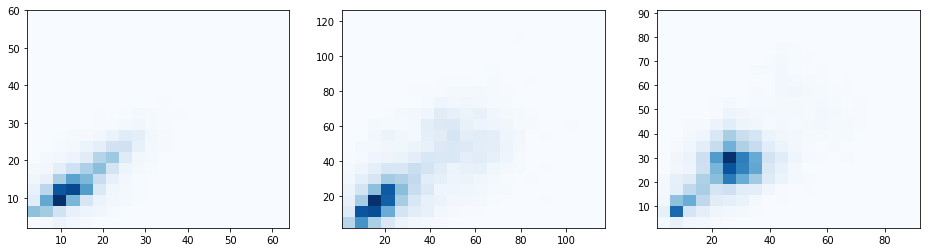

In [15]:
#　核のサイズ統計
fig, ax = plt.subplots(1, len(image_area_bins), figsize=(16, 4))
area_threshold = 0
for i, image_area in enumerate(image_area_bins):
    nucleus_shape = np.array([
        b 
        for s in stats if area_threshold < (s['shape'][0] * s['shape'][1]) <= image_area
        for b in s['bbox']])
    nucleus_area = nucleus_shape[:, 0] * nucleus_shape[:, 1]
    area_threshold = image_area

    print("\nImage Area <= {:.0f}**2".format(np.sqrt(image_area)))
    print("  Total Nuclei: ", nucleus_shape.shape[0])
    print("  Nucleus Height. mean: {:.2f}  median: {:.2f}  min: {:.2f}  max: {:.2f}".format(
        np.mean(nucleus_shape[:, 0]), np.median(nucleus_shape[:, 0]),
        np.min(nucleus_shape[:, 0]), np.max(nucleus_shape[:, 0])))
    print("  Nucleus Width.  mean: {:.2f}  median: {:.2f}  min: {:.2f}  max: {:.2f}".format(
        np.mean(nucleus_shape[:, 1]), np.median(nucleus_shape[:, 1]),
        np.min(nucleus_shape[:, 1]), np.max(nucleus_shape[:, 1])))
    print("  Nucleus Area.   mean: {:.2f}  median: {:.2f}  min: {:.2f}  max: {:.2f}".format(
        np.mean(nucleus_area), np.median(nucleus_area),
        np.min(nucleus_area), np.max(nucleus_area)))

    # Show 2D histogram
    _ = ax[i].hist2d(nucleus_shape[:, 1], nucleus_shape[:, 0], bins=20, cmap="Blues")

Nucleus Aspect Ratio.  mean: 1.09  median: 1.00  min: 0.02  max: 57.00


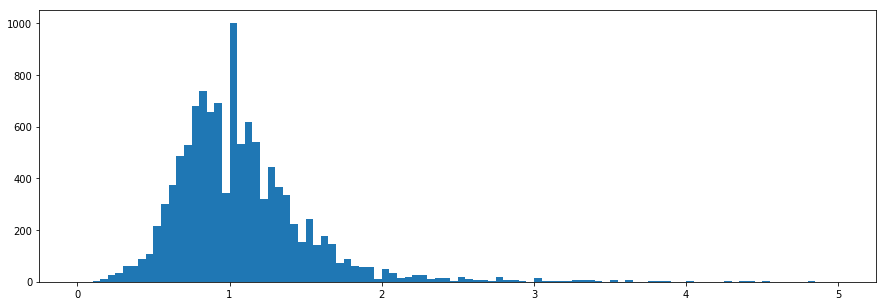

In [130]:
# Nuclei height/width ratio
nucleus_aspect_ratio = nucleus_shape[:, 0] / nucleus_shape[:, 1]
print("Nucleus Aspect Ratio.  mean: {:.2f}  median: {:.2f}  min: {:.2f}  max: {:.2f}".format(
    np.mean(nucleus_aspect_ratio), np.median(nucleus_aspect_ratio),
    np.min(nucleus_aspect_ratio), np.max(nucleus_aspect_ratio)))
plt.figure(figsize=(15, 5))
_ = plt.hist(nucleus_aspect_ratio, bins=100, range=[0, 5])

## イメージ増強

異なる拡張方法をテストする

In [17]:
# List of augmentations
# http://imgaug.readthedocs.io/en/latest/source/augmenters.html
augmentation = iaa.Sometimes(0.9, [      # 全ての画像の約９０％に４つを適用する
    iaa.Fliplr(0.5), # 水平方向に 50% of the images　を反転
    iaa.Flipud(0.5),#垂直方向に全画像の50％を反転
    iaa.Multiply((0.8, 1.2)),#各画像に0.8と1.2の間のランダムな値を掛けます：
    iaa.GaussianBlur(sigma=(0.0, 5.0)) # blur images with a sigma of 0 to 3.0
])

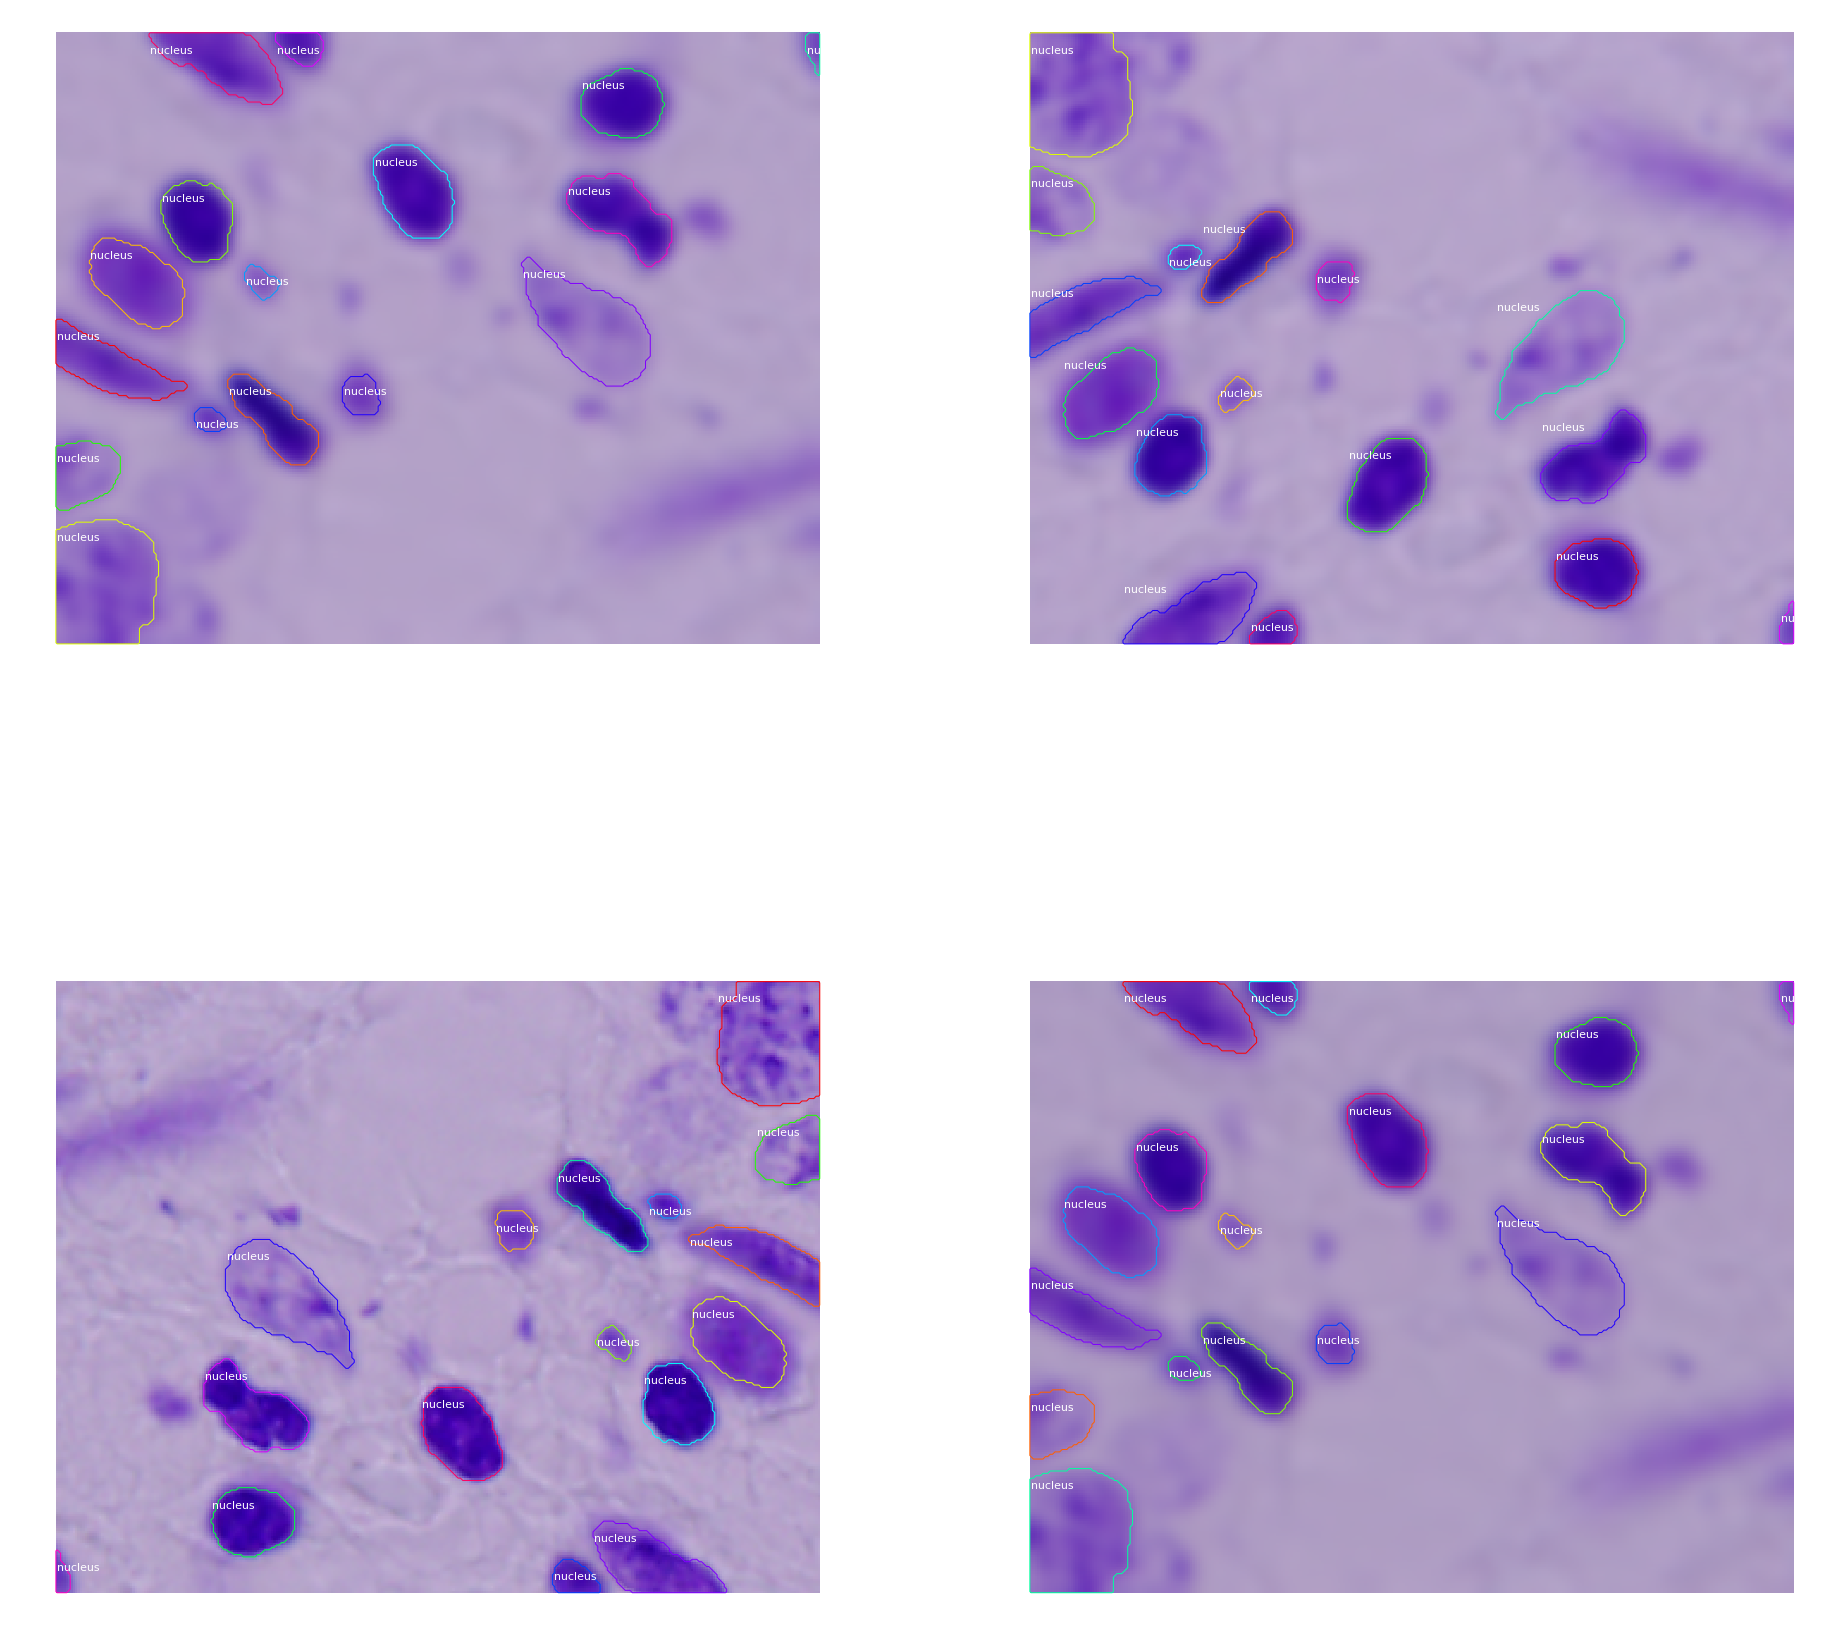

In [128]:
# 画像を複数回読み込んで拡大表示する
limit = 4
ax = get_ax(rows=2, cols=limit//2)
for i in range(limit):
    image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
        dataset, config, image_id, use_mini_mask=False, augment=False, augmentation=augmentation)
    visualize.display_instances(image, bbox, mask, class_ids,
                                dataset.class_names, ax=ax[i//2, i % 2],
                                show_mask= False, show_bbox=False)

## Image Crops
Microscoy画像は大きくなる傾向がありますが、核は小さいです。 したがって、大きな画像からランダムな'crop'を訓練する方が効率的です。 これは `config.IMAGE_RESIZE_MODE =" crop "`によって処理されます。

In [19]:
class RandomCropConfig(nucleus.NucleusConfig):
    IMAGE_RESIZE_MODE = "crop"
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256

crop_config = RandomCropConfig()

In [39]:
np.random.choice(dataset.image_ids, 1)

array([280])

In [40]:
ax

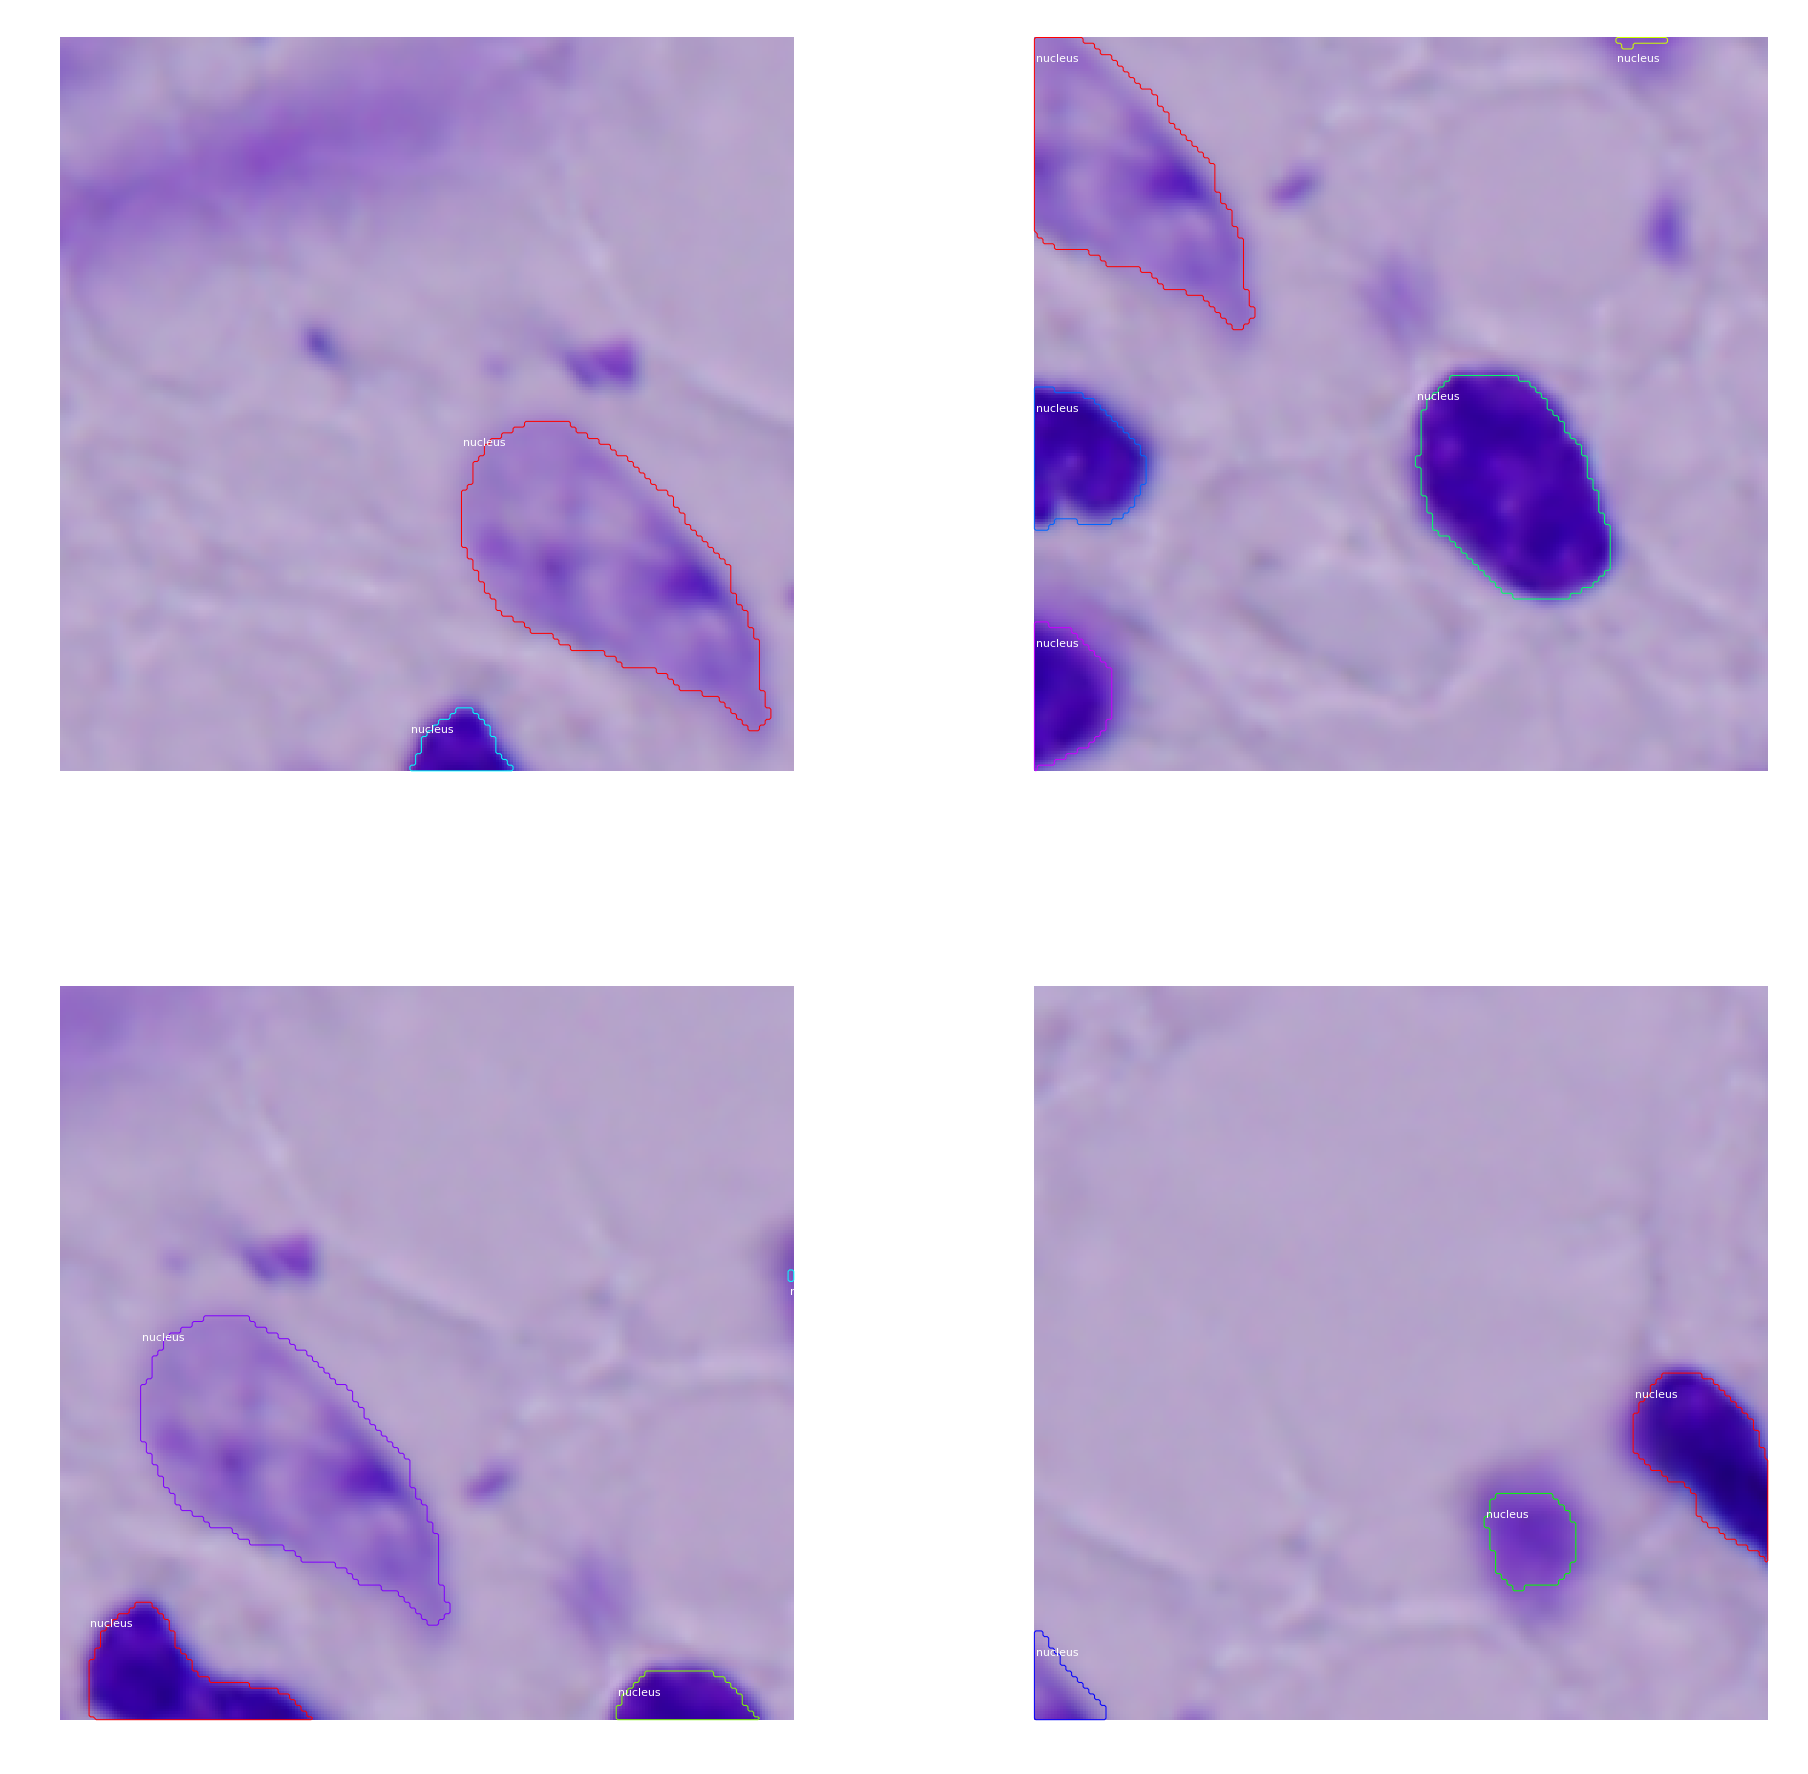

In [105]:
# 画像を複数回読み込んで拡大表示する
limit = 4
image_id = np.random.choice(dataset.image_ids, 1)[0]
ax = get_ax(rows=2, cols=limit//2)
for i in range(limit):
    image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
        dataset, crop_config, image_id, use_mini_mask=False)
    visualize.display_instances(image, bbox, mask, class_ids,
                                dataset.class_names, ax=ax[i//2, i % 2],
                                show_mask=False, show_bbox=False)

## Mini Masks

インスタンスバイナリマスクは、高解像度の画像でトレーニングするときに大きくなることがあります。 たとえば、1024x1024イメージのトレーニングの場合、単一インスタンスのマスクには1MBのメモリが必要です（Numpyはブール値のバイトを使用します）。 画像に100のインスタンスがある場合は、マスクだけの場合は100MBです。

トレーニングのスピードを上げるために、マスクを最適化します。
*我々は、オブジェクトの境界ボックスの内側にあるマスクピクセルを、完全なイメージのマスクではなく格納します。 ほとんどのオブジェクトはイメージサイズに比べて小さいので、オブジェクトの周りに多くのゼロを格納しないことでスペースを節約します。
*マスクのサイズを小さくしてサイズを変更します（56x56など）。 選択したサイズよりも大きいオブジェクトの場合、少し精度が失われます。 しかし、ほとんどのオブジェクト注釈はあまり正確ではありませんので、この損失はほとんどの実用的な目的では無視できません。 mini_maskのサイズは、configクラスで設定できます。

マスクのサイズ変更の効果を視覚化し、コードの正確性を検証するために、いくつかの例を示します。

image_id:  157 8d9b4205ddb10fa49a2973b4f3a2dc6923407ae015081e1a52c4b4c2fe8faa53
Original shape:  (256, 256, 3)
image                    shape: (256, 256, 3)         min:    1.00000  max:  204.00000  uint8
mask                     shape: (256, 256, 33)        min:    0.00000  max:    1.00000  bool
class_ids                shape: (33,)                 min:    1.00000  max:    1.00000  int32
bbox                     shape: (33, 4)               min:    2.00000  max:  256.00000  int32


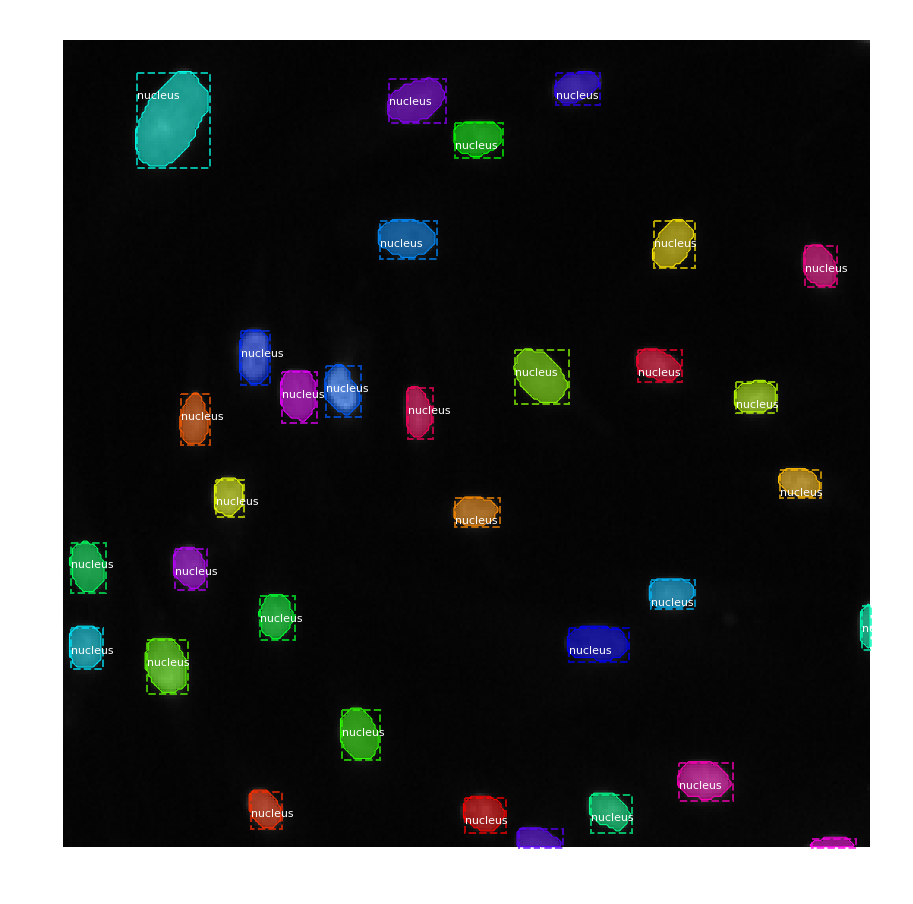

In [100]:
# ランダムな画像とマスクを読み込みます。
image_id = np.random.choice(dataset.image_ids, 1)[0]
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
original_shape = image.shape
# リサイズ
'''image :image.astype(image_dtype)
    window = (0, 0, min_dim, min_dim)
    scale = 1
    padding = [(0, 0), (0, 0), (0, 0)]
'''
image, window, scale, padding, _ = utils.resize_image(
    image, 
    min_dim=config.IMAGE_MIN_DIM,   
    max_dim=config.IMAGE_MAX_DIM, 
    mode=config.IMAGE_RESIZE_MODE)# crop
# maskのリサイズ
mask = utils.resize_mask(mask, scale, padding)
# 境界ボックスの計算
bbox = utils.extract_bboxes(mask)

# 画像とその他の統計情報を表示する
print("image_id: ", image_id, dataset.image_reference(image_id))
print("Original shape: ", original_shape)
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# 画像とインスタンスを表示する
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

image                    shape: (520, 696, 3)         min:    0.00000  max:  174.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max:  696.00000  int64
class_ids                shape: (148,)                min:    1.00000  max:    1.00000  int32
bbox                     shape: (148, 4)              min:    0.00000  max:  696.00000  int32
mask                     shape: (520, 696, 148)       min:    0.00000  max:    1.00000  bool


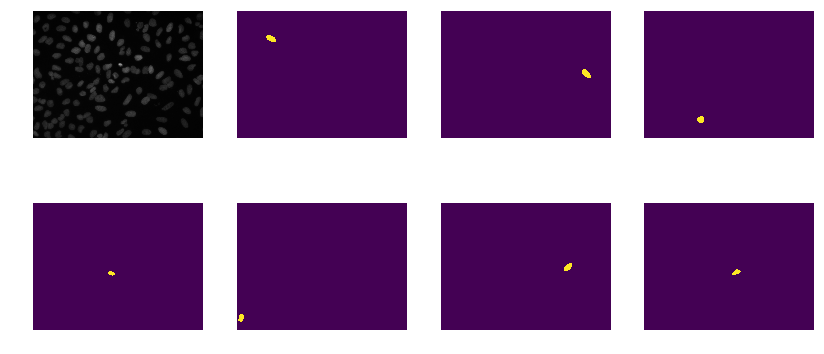

In [93]:
image_id = np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset, config, image_id, use_mini_mask=False)

log("image", image)
log("image_meta", image_meta)
log("class_ids", class_ids)
log("bbox", bbox)
log("mask", mask)

display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

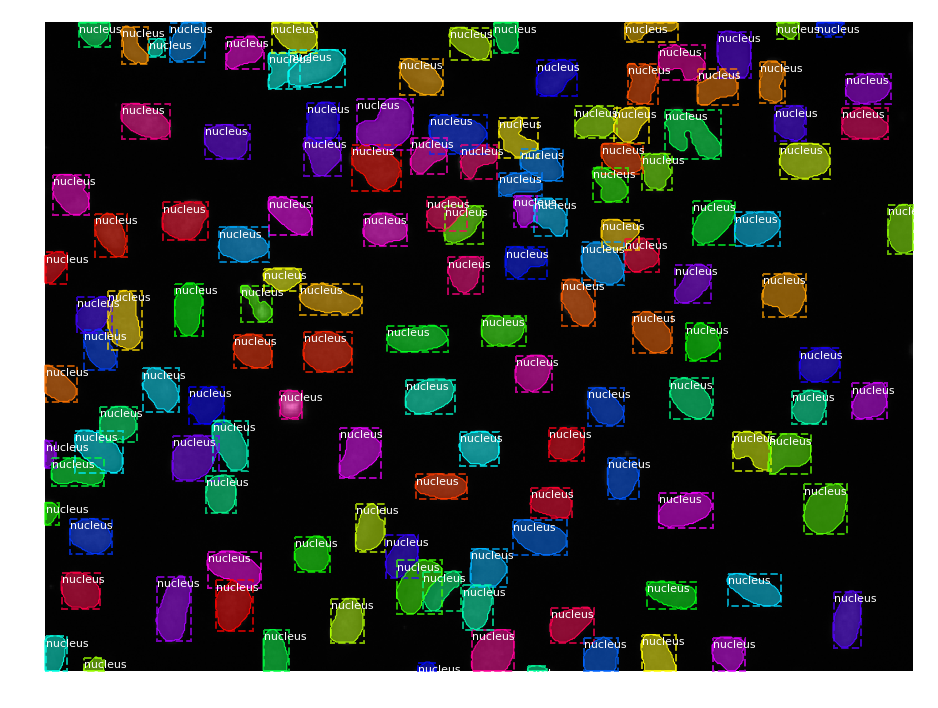

In [38]:
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

mask                     shape: (56, 56, 148)         min:    0.00000  max:    1.00000  bool


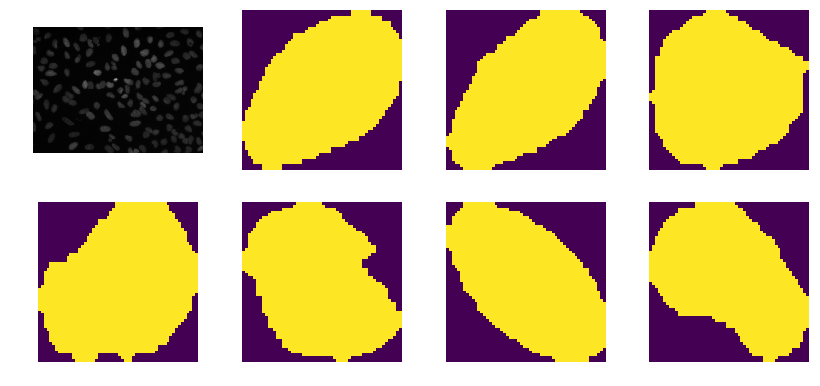

In [95]:
# 増補とマスクのサイズ変更を追加
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset, config, image_id, augment=True, use_mini_mask=True)
log("mask", mask)
display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

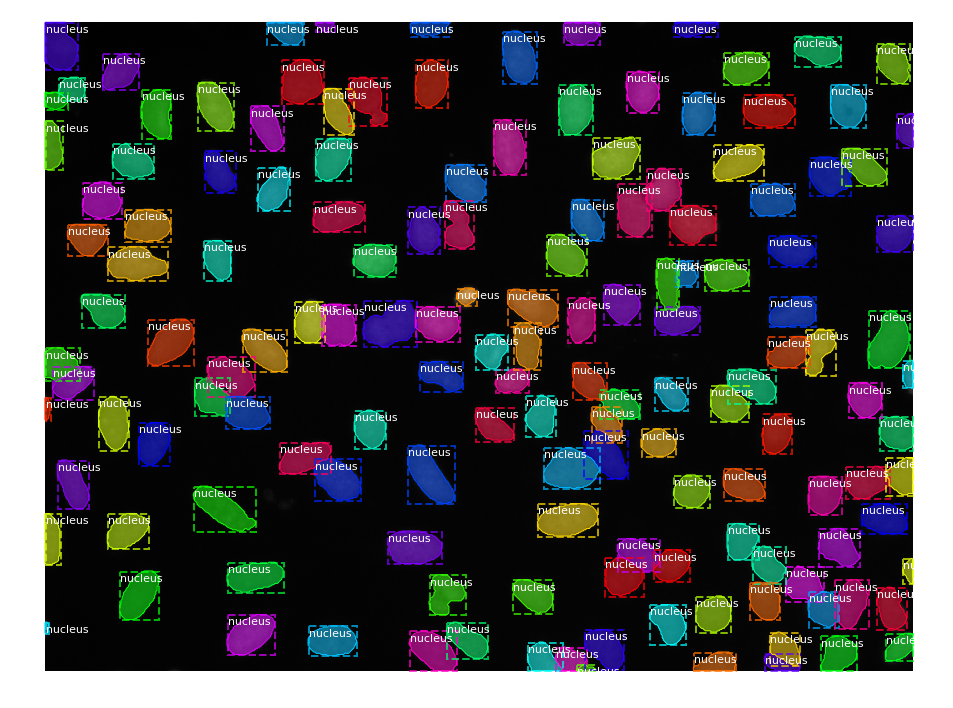

In [96]:
mask = utils.expand_mask(bbox, mask, image.shape)
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

## Anchors
FPNネットワークでは、アンカースコアとシフトを予測する畳み込みレイヤの出力にアンカーを簡単に一致させる方法で、アンカーを並べる必要があります。  
*最初にピラミッドレベルでソートします。 第1レベルのすべてのアンカー、次に第2レベルのアンカーなど。 これにより、レベルごとにアンカーを分離することが容易になります。  
*各レベル内で、フィーチャマップ処理シーケンスでアンカーをソートします。 通常、畳み込みレイヤーは、左上から右に1行ずつ移動するフィーチャーマップを処理します。  
*各フィーチャマップセルに対して、異なる比率のアンカーのソート順を選択します。 ここでは、関数に渡される比率の順序に一致します。
 > https://arxiv.org/abs/1612.03144

Count:  16368
Scales:  (8, 16, 32, 64, 128)
ratios:  [0.5, 1, 2]
Anchors per Cell:  3
Levels:  5
Anchors in Level 0: 12288
Anchors in Level 1: 3072
Anchors in Level 2: 768
Anchors in Level 3: 192
Anchors in Level 4: 48
Level 0. Anchors:  12288  Feature map Shape: [64 64]
Level 1. Anchors:   3072  Feature map Shape: [32 32]
Level 2. Anchors:    768  Feature map Shape: [16 16]
Level 3. Anchors:    192  Feature map Shape: [8 8]
Level 4. Anchors:     48  Feature map Shape: [4 4]


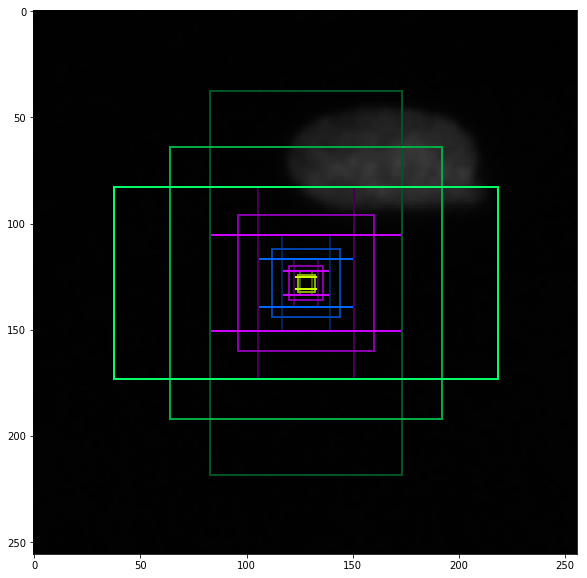

In [26]:
## 1つのセルのアンカーをフィーチャーマップの中心に表示する

# アンカーの要約を印刷する
num_levels = len(backbone_shapes)
anchors_per_cell = len(config.RPN_ANCHOR_RATIOS)
print("Count: ", anchors.shape[0])
print("Scales: ", config.RPN_ANCHOR_SCALES)
print("ratios: ", config.RPN_ANCHOR_RATIOS)
print("Anchors per Cell: ", anchors_per_cell)
print("Levels: ", num_levels)
anchors_per_level = []
for l in range(num_levels):
    num_cells = backbone_shapes[l][0] * backbone_shapes[l][1]
    anchors_per_level.append(anchors_per_cell * num_cells // config.RPN_ANCHOR_STRIDE**2)
    print("Anchors in Level {}: {}".format(l, anchors_per_level[l]))

# Display
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(image)
levels = len(backbone_shapes)

for level in range(levels):
    colors = visualize.random_colors(levels)
    # 画像の中心にアンカーのインデックスを計算する
    level_start = sum(anchors_per_level[:level]) # sum of anchors of previous levels
    level_anchors = anchors[level_start:level_start+anchors_per_level[level]]
    print("Level {}. Anchors: {:6}  Feature map Shape: {}".format(level, level_anchors.shape[0], 
                                                                backbone_shapes[level]))
    center_cell = backbone_shapes[level] // 2
    center_cell_index = (center_cell[0] * backbone_shapes[level][1] + center_cell[1])
    level_center = center_cell_index * anchors_per_cell 
    center_anchor = anchors_per_cell * (
        (center_cell[0] * backbone_shapes[level][1] / config.RPN_ANCHOR_STRIDE**2) \
        + center_cell[1] / config.RPN_ANCHOR_STRIDE)
    level_center = int(center_anchor)

    # Draw anchors. Brightness show the order in the array, dark to bright.
    for i, rect in enumerate(level_anchors[level_center:level_center+anchors_per_cell]):
        y1, x1, y2, x2 = rect
        p = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, facecolor='none',
                              edgecolor=(i+1)*np.array(colors[level]) / anchors_per_cell)
        ax.add_patch(p)


## Data Generator

In [27]:
# Create data generator
random_rois = 2000
g = modellib.data_generator(
    dataset, crop_config, shuffle=True, random_rois=random_rois, 
    batch_size=4,
    detection_targets=True)

In [29]:
# Get Next Image
if random_rois:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_class_ids, gt_boxes, gt_masks, rpn_rois, rois], \
    [mrcnn_class_ids, mrcnn_bbox, mrcnn_mask] = next(g)
    
    log("rois", rois)
    log("mrcnn_class_ids", mrcnn_class_ids)
    log("mrcnn_bbox", mrcnn_bbox)
    log("mrcnn_mask", mrcnn_mask)
else:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_boxes, gt_masks], _ = next(g)
    
log("gt_class_ids", gt_class_ids)
log("gt_boxes", gt_boxes)
log("gt_masks", gt_masks)
log("rpn_match", rpn_match, )
log("rpn_bbox", rpn_bbox)
image_id = modellib.parse_image_meta(image_meta)["image_id"][0]
print("image_id: ", image_id, dataset.image_reference(image_id))

# Remove the last dim in mrcnn_class_ids. It's only added
# to satisfy Keras restriction on target shape.
mrcnn_class_ids = mrcnn_class_ids[:,:,0]

rois                     shape: (4, 128, 4)           min:    0.00000  max:  255.00000  int32
mrcnn_class_ids          shape: (4, 128, 1)           min:    0.00000  max:    1.00000  int32
mrcnn_bbox               shape: (4, 128, 2, 4)        min:   -3.37209  max:    4.23077  float32
mrcnn_mask               shape: (4, 128, 28, 28, 2)   min:    0.00000  max:    1.00000  float32
gt_class_ids             shape: (4, 20)               min:    0.00000  max:    1.00000  int32
gt_boxes                 shape: (4, 20, 4)            min:    0.00000  max:  256.00000  int32
gt_masks                 shape: (4, 56, 56, 20)       min:    0.00000  max:    1.00000  bool
rpn_match                shape: (4, 16368, 1)         min:   -1.00000  max:    1.00000  int32
rpn_bbox                 shape: (4, 64, 4)            min:   -5.19860  max:    2.87262  float64
image_id:  477 06c779330d6d3447be21df2b9f05d1088f5b3b50dc48724fc130b1fd2896a68c


anchors                  shape: (16368, 4)            min:  -90.50967  max:  282.50967  float64
refined_anchors          shape: (3, 4)                min:    0.00000  max:  256.00000  float32
Positive anchors: 3
Negative anchors: 61
Neutral anchors: 16304
BG                     : 95
nucleus                : 33


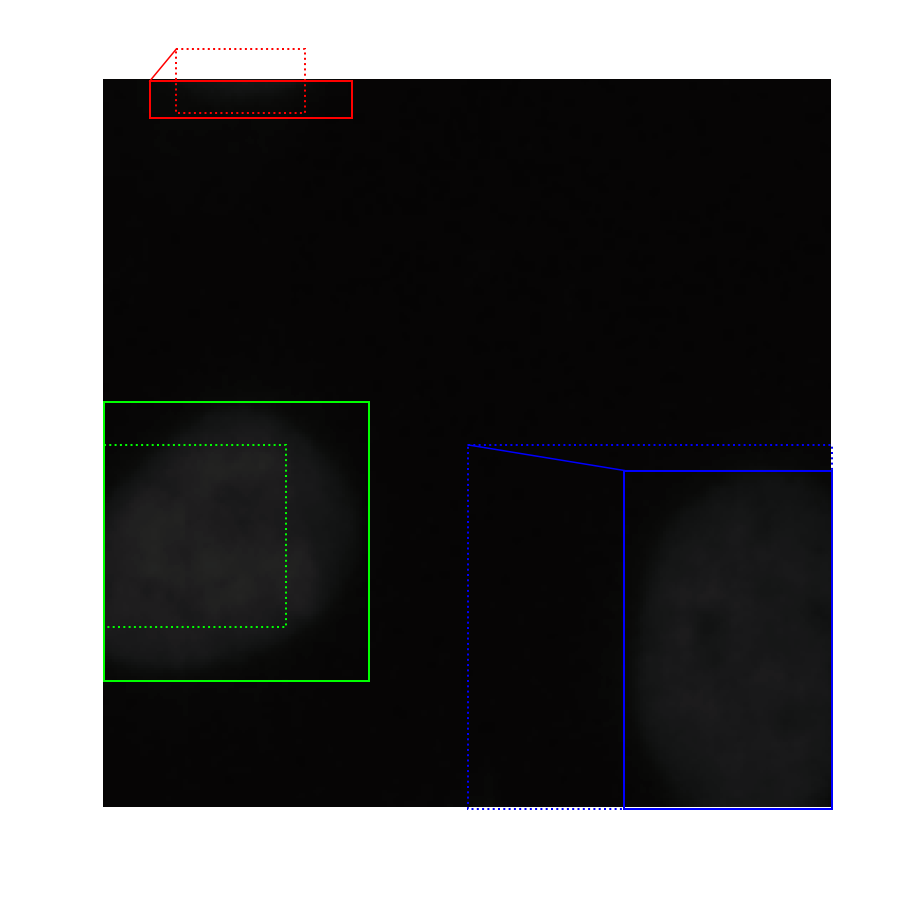

In [122]:
b = 0

# Restore original image (reverse normalization)
sample_image = modellib.unmold_image(normalized_images[b], config)

# Compute anchor shifts.
indices = np.where(rpn_match[b] == 1)[0]
refined_anchors = utils.apply_box_deltas(anchors[indices], rpn_bbox[b, :len(indices)] * config.RPN_BBOX_STD_DEV)
log("anchors", anchors)
log("refined_anchors", refined_anchors)

# Get list of positive anchors
positive_anchor_ids = np.where(rpn_match[b] == 1)[0]
print("Positive anchors: {}".format(len(positive_anchor_ids)))
negative_anchor_ids = np.where(rpn_match[b] == -1)[0]
print("Negative anchors: {}".format(len(negative_anchor_ids)))
neutral_anchor_ids = np.where(rpn_match[b] == 0)[0]
print("Neutral anchors: {}".format(len(neutral_anchor_ids)))

# ROI breakdown by class
for c, n in zip(dataset.class_names, np.bincount(mrcnn_class_ids[b].flatten())):
    if n:
        print("{:23}: {}".format(c[:20], n))

# Show positive anchors
fig, ax = plt.subplots(1, figsize=(16, 16))
visualize.draw_boxes(sample_image, boxes=anchors[positive_anchor_ids], 
                     refined_boxes=refined_anchors, ax=ax)

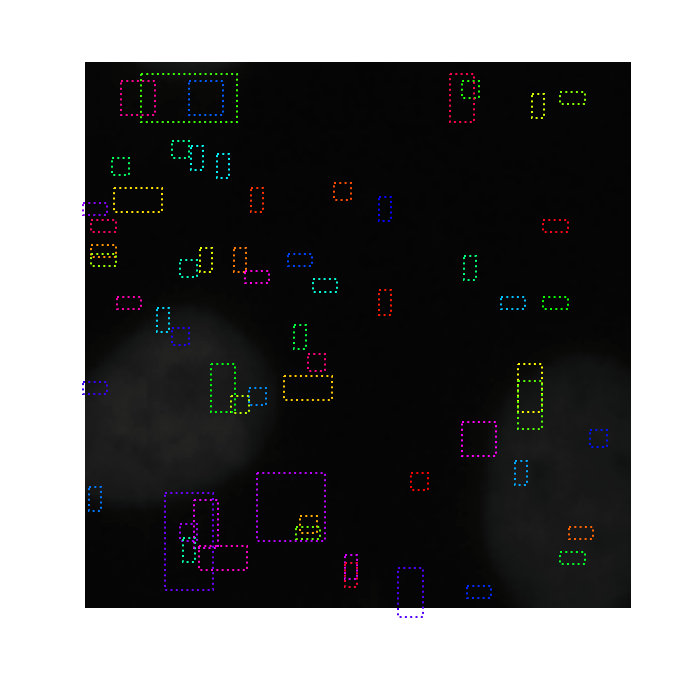

In [107]:
# Show negative anchors
visualize.draw_boxes(sample_image, boxes=anchors[negative_anchor_ids])

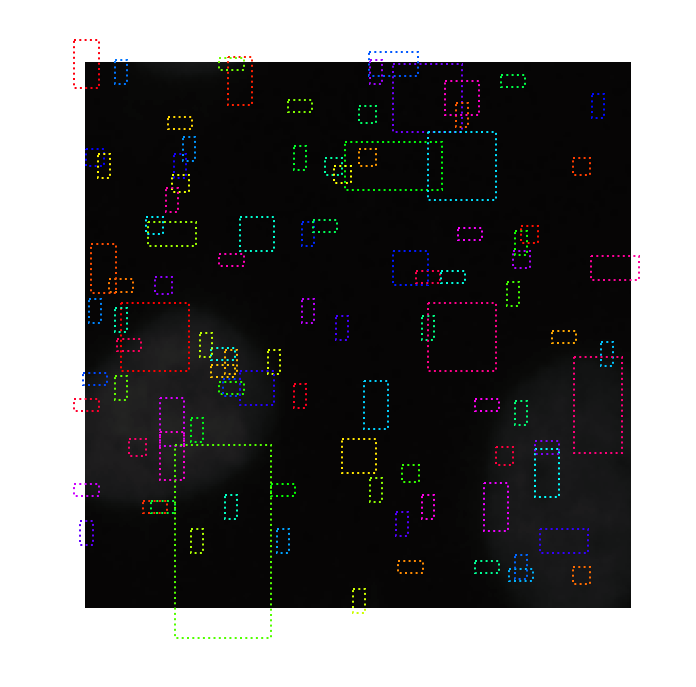

In [124]:
# Show neutral anchors. They don't contribute to training.
visualize.draw_boxes(sample_image, boxes=anchors[np.random.choice(neutral_anchor_ids, 100)])

## ROIs

典型的には、RPNは、候補領域（関心領域、またはROI）を生成する。 データジェネレータには、イラストレーションやテストの目的でプロポーザルを生成する機能もあります。 これらは `random_rois`パラメータによって制御されます。

Positive ROIs:  33
Negative ROIs:  95
Positive Ratio: 0.26
Unique ROIs: 128 out of 128


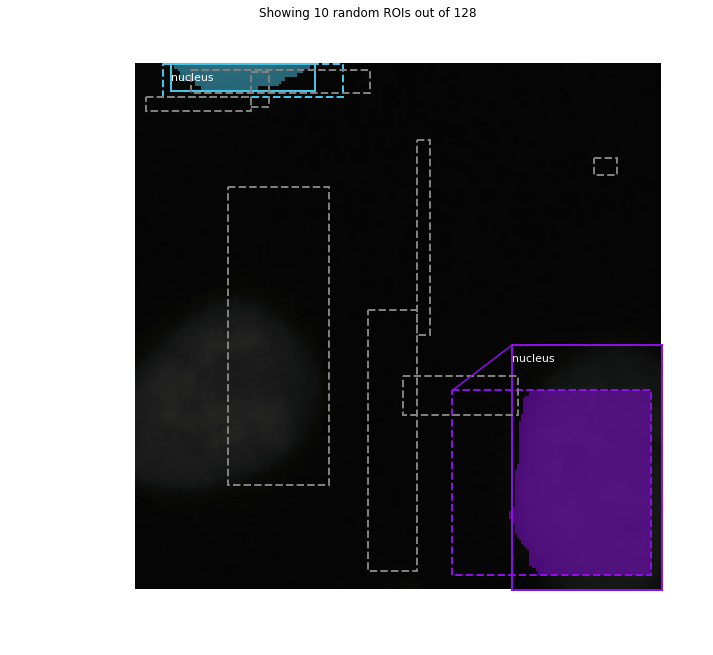

In [33]:
if random_rois:
    # Class aware bboxes
    bbox_specific = mrcnn_bbox[b, np.arange(mrcnn_bbox.shape[1]), mrcnn_class_ids[b], :]

    # Refined ROIs
    refined_rois = utils.apply_box_deltas(rois[b].astype(np.float32), bbox_specific[:,:4] * config.BBOX_STD_DEV)

    # Class aware masks
    mask_specific = mrcnn_mask[b, np.arange(mrcnn_mask.shape[1]), :, :, mrcnn_class_ids[b]]

    visualize.draw_rois(sample_image, rois[b], refined_rois, mask_specific, mrcnn_class_ids[b], dataset.class_names)
    
    # Any repeated ROIs?
    rows = np.ascontiguousarray(rois[b]).view(np.dtype((np.void, rois.dtype.itemsize * rois.shape[-1])))
    _, idx = np.unique(rows, return_index=True)
    print("Unique ROIs: {} out of {}".format(len(idx), rois.shape[1]))

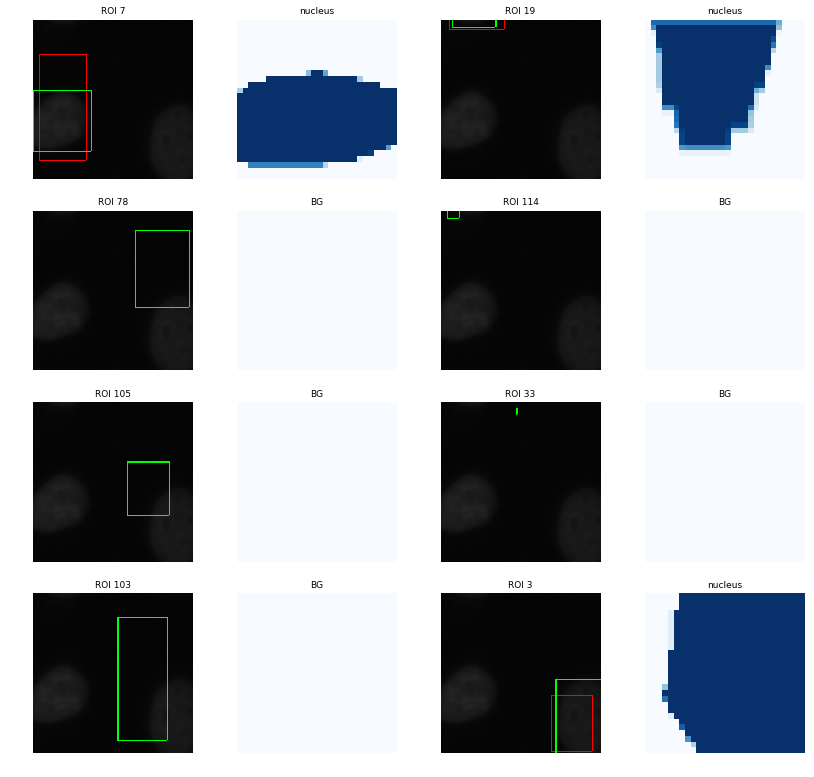

In [34]:
if random_rois:
    # Dispalay ROIs and corresponding masks and bounding boxes
    ids = random.sample(range(rois.shape[1]), 8)

    images = []
    titles = []
    for i in ids:
        image = visualize.draw_box(sample_image.copy(), rois[b,i,:4].astype(np.int32), [255, 0, 0])
        image = visualize.draw_box(image, refined_rois[i].astype(np.int64), [0, 255, 0])
        images.append(image)
        titles.append("ROI {}".format(i))
        images.append(mask_specific[i] * 255)
        titles.append(dataset.class_names[mrcnn_class_ids[b,i]][:20])

    display_images(images, titles, cols=4, cmap="Blues", interpolation="none")

In [35]:
# Check ratio of positive ROIs in a set of images.
if random_rois:
    limit = 10
    temp_g = modellib.data_generator(
        dataset, crop_config, shuffle=True, random_rois=10000, 
        batch_size=1, detection_targets=True)
    total = 0
    for i in range(limit):
        _, [ids, _, _] = next(temp_g)
        positive_rois = np.sum(ids[0] > 0)
        total += positive_rois
        print("{:5} {:5.2f}".format(positive_rois, positive_rois/ids.shape[1]))
    print("Average percent: {:.2f}".format(total/(limit*ids.shape[1])))

   42  0.33
   42  0.33
   42  0.33
   42  0.33
   42  0.33
   42  0.33
   42  0.33
   42  0.33
   42  0.33
   42  0.33
Average percent: 0.33
